# Grover's Algorithm in a n$^2$ x n$^2$ search space

In 1996, Lov Grover showed that a quantum computer can be utilized to obtain a quadratic speedup in an algorithmic unstructured search. Grover's algorithm has four main steps:
1. The initial state preparation. A Hadamard transformation (|$\psi$$\rangle$: H($|0 \rangle$$^\otimes$$^n$|1$\rangle$) is applied to each qubit, putting the qubits in a state of equal superposition.
2. The oracle ('black box') implementation. An oracle is used to recognize the solution and mark the target states.
3. Amplitude amplification operation, or a diffuser application. The diffuser takes the state marked by the oracle and increases the probability of measuring the correct solution. The marked state will be described by a 'negative' value. The diffuser will detect the state with a phase difference.
4. The Grover iteration. Repetition of steps 2 and 3 (($\pi$/4)$\sqrt{N}$) a specific number of times and observation of the solution with high probability

Consider a 4x4 Sudoku puzzle with 16 cells and 2 qubits per cell. Assume that the data is labeled as n-bit boolean strings in {0,1}
rather than being indexed from 1 to N and implement Grover's algorithm to solve the puzzle.

In [129]:
#Brief outline below

In [130]:
#Import necessary packages
#Consider a 4x4 Sudoku puzzle shape using '*' for empty cells
#Define a list of constraints and parameters based on the rules of Sudoku
#Build an oracle specific to a 4x4 Sudoku space
#Build a diffuser
#Establish Grover's circuit (state prep, oracle and diffuser)
#Run Grover's algorithm the necessary amount of times
#Find statevector
#Give solution with probabilities

In [131]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector, Operator

import matplotlib.pyplot as plt
from itertools import combinations
from math import pi, ceil, log2, floor, sqrt
import numpy as npv
from qiskit.quantum_info import Operator
from qiskit.circuit.library import MCMT
import numpy as np

Figure I shows a 4x4 Sudoku puzzle shape (ExampleA) using "*" for empty cells. The 4x4 grid contains 16 spaces and 4 sub-grids. The goal is to get the numbers 0 through 3 in each sub‐grid without repeating any of the values in the rows or columns.

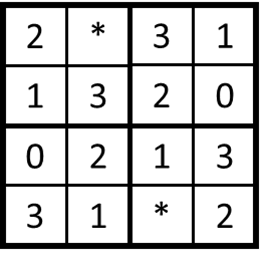

Figure I: An example of an unsolved 4x4 Sudoku puzzle with values from 0 to 3 and two missing or empty spaces represented by "*".

In [132]:
n = 2
ExampleA = np.array([2, '*', 3, 1, 1, 3, 2, 0, 0, 2, 1, 3, 3, 1, '*', 2])
ExampleA = ExampleA.reshape(4, 4)

ExampleA

array([['2', '*', '3', '1'],
       ['1', '3', '2', '0'],
       ['0', '2', '1', '3'],
       ['3', '1', '*', '2']], dtype='<U21')

In [133]:
#Identify empty (*) cells 

def empty(ExampleA):
    missing = []
    for i in range(len(ExampleA)):
        for j in range(len(ExampleA)):
            if ExampleA[i][j] == '*':
                missing.append([i, j])
    return missing
    
#Count the number of * in this case

missing_positions = empty(ExampleA)
num_missing = len(missing_positions)
print(f"Number of unknowns {num_missing}")

Number of unknowns 2


In [134]:
missing_positions #recall, using values from 0 to 3

[[0, 1], [3, 2]]

In [135]:
#Define a valid Sudoku puzzle (the search space)

def possible_candidate(ExampleA, empty, candidate):
    new_puzzle = [row.copy() for row in puzzle]
    for (i, j), val in zip(empty, candidate):
        new_puzzle[i][j] = val
    return new_puzzle

 
#4x4 matrix containing empty (*), or missing values, and numbers 0, 1, 2 and 3. Each matrix element is represented by two bits

#n^2= 4; block_size = 2

#Constraints on rows, columns and boxes with 3(n^2 -1) constraints per blank

n=2
def confirm_sudoku_constraints(ExampleA):

    constraints = []

    for i in range(len(missing_positions)):
        row = missing_positions[i][0]
        column = missing_positions[i][1]
      
    #Row constraints
        for j in range(n**2):
          if j != column:
            if ExampleA[row][j] == '*':
              constraints.append([2*i, 2*missing_positions.index([row, j]) ])
            else:
              constraints.append([2*i, ExampleA[row][j]])
            
    #Column constraints
        for j in range(n**2):
          if j != row:
            if ExampleA[j][column] == '*':
              constraints.append([2*i, 2*missing_positions.index([j, column]) ])
            else:
              constraints.append([2*i, ExampleA[j][column]])
            
    #Box (2x2 sub-grid) constraints
        if row < n:
          if column < n:
            for j in range(n):
              for k in range(n):
                if ExampleA[j][k] == '*':
                  constraints.append([2*i, 2*missing_positions.index([j, k]) ])
                else:
                  constraints.append([2*i, ExampleA[j][k]])
          elif column >= n:
            for j in range(n):
              for k in range(n):
                if ExampleA[j][k + n] == '*':
                  constraints.append([2*i, 2*missing_positions.index([j, k+n]) ])
                else:
                  constraints.append([2*i, ExampleA[j][k+n]])
        elif row >= n:
          if column < n:
            for j in range(n):
              for k in range(n):
                if ExampleA[j + n][k] == '*':
                  constraints.append([2*i, 2*missing_positions.index([j + n, k]) ])
                else:
                  constraints.append([2*i, ExampleA[j + n][k]])
          elif column >= n:
            for j in range(n):
              for k in range(n):
                if ExampleA[j + n][k + n] == '*':
                  constraints.append([2*i, 2*missing_positions.index([j + n, k+n]) ])
                else:
                  constraints.append([2*i, ExampleA[j + n][k+n]])

#Remove duplicate entries
    temp = []
    for i in range(len(constraints)):
        if constraints[i] not in temp and constraints[i][0] != constraints[i][1]:
            temp.append(constraints[i])

    constraints = temp 
 

    return constraints

In [136]:
confirm_sudoku_constraints(ExampleA)

[[0, '2'], [0, '3'], [0, '1'], [2, '3'], [2, '1'], [2, '2']]

Next, map candidate list to a quantum register and illustrate the initial state ("State Prep") of a Grover quantum circuit

In [137]:
QuReg = QuantumRegister(size=4, name = "q");

#Apply H-gate to puzzle qubits and illustrate "State Prep" using quantum circuit
q_qc = QuantumCircuit(QuReg, name = "State Prep");
#Apply H gates
q_qc.h(QuReg);
#Show initial circuit
Initial_Circ = q_qc.to_gate();
q_qc.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘

Secondly, continue the circuit. Build an oracle for a 4x4 Sudoku puzzle using the rules of Sudoku, as described above. Assume that the data is labeled as n-bit boolean strings in {0,1}$^n$ rather than being indexed from 1 to N. The oracle implements a 'negative' phase marker (i.e. flips the phase of a valid candidate).

Recall:

a 2x2 binary Sudoku puzzle ($S$ or ExampleB) with binary strings of bits $s_0$, $s_1$, $s_2$, $s_3$ 
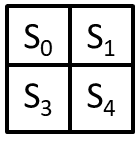
and two solutions

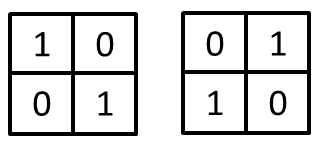
that satisfy the following conditions: 

<center> $s_0$ $\not=$$s_1$, $s_0$ $\not=$$s_2$, $s_1$ $\not=$$s_3$, $s_2$ $\not=$$s_3$ </center>
 and equivalently, 
<center>    $s_0$ $\oplus$$s_1$=1, $s_0$ $\oplus$$s_2$=1, $s_1$ $\oplus$$s_3$=1, $s_2$ $\oplus$$s_3$=1.  </center>

An oracle for a 2x2 Binary Sudoku (S), which utilizes ancilla or auxiliary qubits, is shown below.

In [138]:
m = 4
QuReg2 = QuantumRegister(m, name='s')
ancilla_qubits = AncillaRegister(m, name='aux')
cccz = MCMT('z',3,1)
oracle2 = QuantumCircuit(QuReg, ancilla_qubits, name='Oracle2')
oracle2.cx([0,1,0,2,1,3,2,3],[4,4,5,5,6,6,7,7])
oracle2.compose(cccz, qubits=[4,5,6,7],inplace=True)
oracle2.cx([0,1,0,2,1,3,2,3],[4,4,5,5,6,6,7,7])

oracle2.draw()

/tmp/ipykernel_134/3123244023.py:4: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  cccz = MCMT('z',3,1)


»
  q_0: ──■─────────■──────────────────────────────────■─────────■────────────»
         │         │                                  │         │            »
  q_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
         │    │    │         │                        │    │    │         │  »
  q_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
         │    │    │    │    │         │              │    │    │    │    │  »
  q_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   1-Z ┌─┴─┐┌─┴─┐  │    │    │  »
aux_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
aux_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
aux_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                           └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
aux_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                     └───┘└───┘                              »
«                      
«  q_0: ───────────────
«                      
«  q_1: ───────────────
«                      
«  q_2: ───────■───────
«              │       
«  q_3: ──■────┼────■──
«         │    │    │  
«aux_0: ──┼────┼────┼──
«         │    │    │  
«aux_1: ──┼────┼────┼──
«       ┌─┴─┐  │    │  
«aux_2: ┤ X ├──┼────┼──
«       └───┘┌─┴─┐┌─┴─┐
«aux_3: ─────┤ X ├┤ X ├
«            └───┘└───┘

This shows that the oracle utilizes a CNOT gate with $\ket{s_0}$ (control) and $\ket{aux_0}$ (target), followed by a CNOT gate with$\ket{s_1}$ (control) and $\ket{aux_0}$ (target). Based on constraints, if $\ket{s_0}$ and $\ket{s_1}$ are equal, then $\ket{aux_0}$ remains $\ket{0}$. If $\ket{s_0}$ and $\ket{s_1}$ are different, then $\ket{aux_0}$ flips to $\ket{1}$. Similarly, if $\ket{s_0}$ and $\ket{s_2}$ are equal, then $\ket{aux_1}$ remains $\ket{0}$. If $\ket{s_0}$ and $\ket{s_2}$ are different, then $\ket{aux_1}$ flips to $\ket{1}$. Likewise, if $\ket{s_2}$ and $\ket{s_3}$ are equal, then $\ket{aux_2}$ remains $\ket{0}$. If $\ket{s_2}$ and $\ket{s_3}$ are different, then $\ket{aux_2}$ flips to $\ket{1}$. When $\ket{s_1}$ and $\ket{s_3}$ are equal, then $\ket{aux_3}$ remains $\ket{0}$. If $\ket{s_1}$ and $\ket{s_3}$ are different, then $\ket{aux_3}$ flips to $\ket{1}$. Finally, if all the constraints are satisfied, each ancilla qubits is $\ket{1}$. The phase can then be flipped using a triple controlled Z-gate (cccz). Lastly, the ancilla qubits are brought back to $\ket{0}$ and the gates are applied again.

In the case of an nontrivial, 4x4 Sudoku space, which satisfies the 4x4 puzzle constraints stated above, an oracle is built based on additional conditions using Quantum and Ancilla Registers. For instance, in the case of two missing values, one quantum register of n=4, an ancilla register of 

In [139]:
#Set up quantum circuit for viewing circuit diagram of oracle_A
constraints = confirm_sudoku_constraints(ExampleA)
#quantum register
QuReg = QuantumRegister(size=4, name = "q");
missing = QuantumRegister(size = 2 * num_missing, name = 'e')
#if two bits are equal
bit_cal = AncillaRegister(size = 2, name = 'b')
#check on each blank space
cond = AncillaRegister(size = len(constraints), name = 'c')
#if all conditions have been met
an = AncillaRegister(size = 1, name = 'a')

q_qc = QuantumCircuit(missing, bit_cal, cond, an)

In [140]:
def classical_or(circuit, a, b, c):
  circuit.x(a)
  circuit.x(b)
  circuit.ccx(a, b, c)
  circuit.x(c)

  #Return a and b to original values
  circuit.x(a)
  circuit.x(b)

In [141]:
def different(circuit, a, b, c, d, e, f, g):
  #Compare first bit
  circuit.cx(a, e)
  circuit.cx(c, e)

  #Compare second bit
  circuit.cx(b, f)
  circuit.cx(d, f)

  #Classical or gives 1 if differ on at least one bit, 0 if same on both bits
  classical_or(circuit, e, f, g)

  #Reset e and f to original by redoing unitary
  #Compare first bit
  circuit.cx(a, e)
  circuit.cx(c, e)

  #Compare second bit
  circuit.cx(b, f)
  circuit.cx(d, f)

In [142]:
def oracle_A(circuit, constraints):
  #Fill in all conditions with 1 if satisfied, 0 if not
  for i in range(len(constraints)):
    if constraints[i][1] == np.str_('0'):
      circuit.x(missing[constraints[i][0]])
      circuit.x(missing[constraints[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0]])
      circuit.x(missing[constraints[i][0] + 1])
    elif constraints[i][1] == np.str_('1'):
      circuit.x(missing[constraints[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0] + 1])
    elif constraints[i][1] == np.str_('2'):
      circuit.x(missing[constraints[i][0]])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0]])
    elif constraints[i][1] == np.str_('3'):
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
    else:
      different(circuit, missing[constraints[i][0]], missing[constraints[i][0] + 1], missing[constraints[i][1]], missing[constraints[i][1] + 1], bit_cal[0], bit_cal[1], cond[i])

  #Check if all conditions are met by applying multicontrolled z gate, built from H(mcx)H since Z = HXH
  circuit.h(an)
  circuit.mcx(cond, an)
  circuit.h(an)

  #Reset all of the registers by applying computations again
  for i in range(len(constraints)):
    if constraints[i][1] == np.str_('0'):
      circuit.x(missing[constraints[i][0]])
      circuit.x(missing[constraints[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0]])
      circuit.x(missing[constraints[i][0] + 1])
    elif constraints[i][1] == np.str_('1'):
      circuit.x(missing[constraints[i][0] + 1])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0] + 1])
    elif constraints[i][1] == np.str_('2'):
      circuit.x(missing[constraints[i][0]])
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
      #Return to original value
      circuit.x(missing[constraints[i][0]])
    elif constraints[i][1] == np.str_('3'):
      #If 0, now both bits 1 now, so Toffoli gate flips condition bit to 1, x flips to desired value
      circuit.ccx(missing[constraints[i][0]], missing[constraints[i][0] + 1], cond[i])
      circuit.x(cond[i])
    else:
      different(circuit, missing[constraints[i][0]], missing[constraints[i][0] + 1], missing[constraints[i][1]], missing[constraints[i][1] + 1], bit_cal[0], bit_cal[1], cond[i])



In [143]:
#Run to view circuit diagram
oracle_A(q_qc, constraints)
q_qc.draw()

┌───┐     ┌───┐                         ┌───┐          ┌───┐          »
e_0: ┤ X ├──■──┤ X ├───────■──────────────■──┤ X ├───────■──┤ X ├───────■──»
     └───┘  │  └───┘       │  ┌───┐       │  ├───┤       │  └───┘       │  »
e_1: ───────■──────────────■──┤ X ├───────■──┤ X ├───────■──────────────■──»
            │              │  ├───┤       │  ├───┤       │              │  »
e_2: ──■────┼─────────■────┼──┤ X ├──■────┼──┤ X ├───────┼────■─────────┼──»
       │    │  ┌───┐  │    │  ├───┤  │    │  └───┘       │    │  ┌───┐  │  »
e_3: ──■────┼──┤ X ├──■────┼──┤ X ├──■────┼──────────────┼────■──┤ X ├──┼──»
       │    │  └───┘  │    │  └───┘  │    │              │    │  └───┘  │  »
b_0: ──┼────┼─────────┼────┼─────────┼────┼──────────────┼────┼─────────┼──»
       │    │         │    │         │    │              │    │         │  »
b_1: ──┼────┼─────────┼────┼─────────┼────┼──────────────┼────┼─────────┼──»
       │  ┌─┴─┐┌───┐  │    │         │    │            ┌─┴─┐  │  ┌───┐  │  »
c_0: ──┼──┤ X ├┤ X ├──┼────┼─────────┼────┼─────────■──┤ X ├──┼──┤ X ├──┼──»
       │  └───┘└───┘  │  ┌─┴─┐┌───┐  │    │         │  └───┘  │  └───┘┌─┴─┐»
c_1: ──┼──────────────┼──┤ X ├┤ X ├──┼────┼─────────■─────────┼───────┤ X ├»
       │              │  └───┘└───┘  │  ┌─┴─┐┌───┐  │         │       └───┘»
c_2: ──┼──────────────┼──────────────┼──┤ X ├┤ X ├──■─────────┼────────────»
     ┌─┴─┐┌───┐       │              │  └───┘└───┘  │       ┌─┴─┐┌───┐     »
c_3: ┤ X ├┤ X ├───────┼──────────────┼──────────────■───────┤ X ├┤ X ├─────»
     └───┘└───┘     ┌─┴─┐┌───┐       │              │       └───┘└───┘     »
c_4: ───────────────┤ X ├┤ X ├───────┼──────────────■──────────────────────»
                    └───┘└───┘     ┌─┴─┐┌───┐       │                      »
c_5: ──────────────────────────────┤ X ├┤ X ├───────■──────────────────────»
     ┌───┐                         └───┘└───┘     ┌─┴─┐┌───┐               »
  a: ┤ H ├────────────────────────────────────────┤ X ├┤ H ├───────────────»
     └───┘                                        └───┘└───┘               »
«                              
«e_0: ────────────■────────────
«     ┌───┐       │  ┌───┐     
«e_1: ┤ X ├───────■──┤ X ├─────
«     └───┘┌───┐  │  └───┘┌───┐
«e_2: ──■──┤ X ├──┼────■──┤ X ├
«       │  ├───┤  │    │  └───┘
«e_3: ──■──┤ X ├──┼────■───────
«       │  └───┘  │    │       
«b_0: ──┼─────────┼────┼───────
«       │         │    │       
«b_1: ──┼─────────┼────┼───────
«       │         │    │       
«c_0: ──┼─────────┼────┼───────
«       │  ┌───┐  │    │       
«c_1: ──┼──┤ X ├──┼────┼───────
«       │  └───┘┌─┴─┐  │  ┌───┐
«c_2: ──┼───────┤ X ├──┼──┤ X ├
«       │       └───┘  │  └───┘
«c_3: ──┼──────────────┼───────
«     ┌─┴─┐┌───┐       │       
«c_4: ┤ X ├┤ X ├───────┼───────
«     └───┘└───┘     ┌─┴─┐┌───┐
«c_5: ───────────────┤ X ├┤ X ├
«                    └───┘└───┘
«  a: ─────────────────────────
«

Build a diffuser for n number of qubits ("general diffuser")

def diffuser(nqubits):
    QuReg = QuantumRegister(size=nqubits, name = "q");
    diffuser_circuit = QuantumCircuit(nqubits, name = "diffuser")
    
    # Apply transformation (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # Apply X-gates
    for qubit in range(nqubits):
        qc.x(qubit)
        
    # Multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mcx(list(range(nqubits-1)), nqubits-1)
    qc.h(nqubits-1)
    
    # Apply X-gate
    for qubit in range(nqubits):
        qc.x(qubit)
        
    # Apply H-gates
    for qubit in range(nqubits):
        qc.h(qubit)
        
    # Return diffuser as a gate
    D = diffuser_circuit.to_gate()
 
    return diffuser

Illustrate the diffuser in a circuit

In [144]:
QuReg = QuantumRegister(size=4, name = "q");
Diff_qc = QuantumCircuit(QuReg, name = "diffuser")
Diff_qc.h(QuReg);
Diff_qc.x(QuReg);
Diff_qc.h(QuReg[-1]);
Diff_qc.mcx(QuReg[0:-1], QuReg[-1]);
Diff_qc.h(QuReg[-1]);
Diff_qc.x(QuReg);
Diff_qc.h(QuReg);

Diff_qc.draw()

┌───┐┌───┐          ┌───┐┌───┐     
q_0: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_1: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤       │  ├───┤├───┤     
q_2: ┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────
     ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐
q_3: ┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├
     └───┘└───┘└───┘└───┘└───┘└───┘└───┘

In [145]:
def diffuser(nqubits):
    QuReg = QuantumRegister(size=nqubits, name = "q");
    diffuser_circuit = QuantumCircuit(QuReg, name = "diffuser") 
    diffuser_circuit.h(QuReg)
    diffuser_circuit.x(QuReg)

    diffuser_circuit.h(nqbits-1)
    diffuser_circuit.mcx(list(range(nqbits-1)), nqubits-1)
    diffuser_circuit.h(nqubits-1)

    diffuser_circuit.x(QuReg)
    diffuser_circuit.h(QuReg)

    D = diffuser_circuit.to_gate()
    return D

Finally, create the completed grover curcuit.

In [146]:
# numbers and numbers missing for 4x4 Sudoku search space
n= 4
N = n ** num_missing
nqubits = 2 * num_missing + 4 + 2 * (n**2) + 1
max_iterations=101

def grover_iterations(num_missing,numbers):

  #Optimal number of iterations:
  optimal= np.pi * np.sqrt(N) / 4
  iterations = int(np.floor(optimal))
  #Successful
  theta = (2* iterations +1)* np.arcsin(1/np.sqrt(N))
  success_prob=np.sin(theta)**2

  print(f"Number of Iterations:{iterations}")
  return iterations

iterations = grover_iterations(num_missing,n)

Number of Iterations:3


In [150]:
max_iterations=101
nqubits = 2 * num_missing + 2 + len(constraints) + 1
def results(num_missing, nqubits, n, max_iterations):
    
    gc = QuantumCircuit(nqubits);
    
    if max_iterations is not None and max_iterations < iterations:
      t = max_iterations
      print(f"Using {t} iterations (reduced from optimal number of iterations {iterations})")
    else:
      t = iterations

    blanks_temp = QuantumRegister(size = 2 * num_missing, name = 'e')
    bit_cal_temp = AncillaRegister(size = 2, name = 'b')
    cond_temp = AncillaRegister(size = len(cond), name = 'c')
    an_temp = AncillaRegister(size = 1, name = 'a')

    temp_oracle_circuit = QuantumCircuit()

    temp_oracle_circuit.add_register(blanks_temp)
    temp_oracle_circuit.add_register(bit_cal_temp)
    temp_oracle_circuit.add_register(cond_temp)
    temp_oracle_circuit.add_register(an_temp)

    oracle_A(temp_oracle_circuit, constraints)

  # temporary circuit (only gate operations) to a gate
    oracle_gate = temp_oracle_circuit.to_gate(label="Oracle A")

  # The diffuser function directly returns a gate
    diffuser_gate = diffuser(2 * num_missing)#.to_gate(label="Diffuser")

    gc.initialize([1, -1]/np.sqrt(2), nqubits - 1)

  # Initialize the blank qubits to a uniform superposition
    gc.h(range(2 * num_missing))

  # Apply the iterations
    print(f"Running {t}-many Grover iterations")
    for i in range(t):
        if i % 10 == 0:
            print(f"Iteration {i}/{t}")

        gc.append(oracle_gate, range(nqubits))
        gc.append(diffuser_gate, range(2 * num_missing))


# The statevector
    statevector = Statevector(gc)

# Probabilities
    prob = statevector.probabilities()

# Max prob index and corresponding binary string
    most_probable_index = prob.argmax()

    nqubits = gc.nqubits
    most_probable_state = format(most_probable_index, f'0{nqubits}b')
    most_probable_state = most_probable_state[len(most_probable_state) - 2* num_missing:]

    print("Probabilities:", prob)
    print("Solution:", most_probable_state)
    print("Success probability:", prob[most_probable_index])
    
    return most_probable_state
#RUN

solution = results(num_missing, nqubits, n, max_iterations)  

Running 3-many Grover iterations
Iteration 0/3


AttributeError: 'QuantumCircuit' object has no attribute 'nqubits'

In [152]:
def decode_solution(binary_string, empty, ExampleA):
  final_solution = ExampleA
  for i in range(len(empty)):
    bits1, bits2 = binary_string[2*i], binary_string[2*i + 1]
    bits1 = int(bits1)
    bits2 = int(bits2)
    value = 2*(bits1) + bits2
    location = missing[len(empty)-i-1]
    final_solution[location[0]][location[1]] = value
  return final_solution

decode_solution(solution, empty, exampleA)

NameError: name 'solution' is not defined

While quantum computational methods have seen some advances, the hardware to run Grover's algorithm at a meaningful scale has not yet been realized.
However, these breakthroughs in quantum computing algorithms are powerful reminders of the potential of quantum computer. 

References

Grover, L.K., 1996, July. A fast quantum mechanical algorithm for database search. In Proceedings of the twenty-eighth annual ACM symposium on Theory of computing (pp. 212-219).

Nielsen, M.A. and Chuang, I.L., 2010. Quantum computation and quantum information. Cambridge university press.